**Deep Learning - Redes Recorrentes**

> 12/04/2024




**Integrantes**

- André Luiz Pires Guimarães
- Daniel de Souza Miranda
- Iago Nery Mendes
- Lucas Elias de Andrade Cruvinel
- Victor Hugo Brito da Silva Miranda

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set(style="darkgrid", font_scale=1.5)

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Lendo o CSV e visualizando os dados. Como se tratam de dados temporais, utilizarmos a coluna "timestamp" como índice.

In [ ]:
df = pd.read_csv("RecurrentNeuralNetwork/stock_data.csv", parse_dates=["timestamp"], index_col="timestamp")
df.shape

In [ ]:
df.head()

Os dados contêm mais de 1600 linhas (uma para cada dia), e 11 colunas. Vamos remover todas as colunas exceto a coluna "close" (único dado de interesse)

In [ ]:
df.drop('high', axis=1, inplace=True)
df.drop('low', axis=1, inplace=True)
df.drop('open', axis=1, inplace=True)
df.drop('volume', axis=1, inplace=True)
df.drop('close_time', axis=1, inplace=True)
df.drop('quote_av', axis=1, inplace=True)
df.drop('trades', axis=1, inplace=True)
df.drop('tb_base_av', axis=1, inplace=True)
df.drop('tb_quote_av', axis=1, inplace=True)
df.drop('ignore', axis=1, inplace=True)

#df['close'] = df['close'].pct_change() # mudaria para porcentagem de mudança
df.dropna(how='any', axis=0, inplace=True)

df.shape

In [ ]:
df.tail()

Vamos verificar os dados temporais plotados.

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="close", data=df).set_title("Variações de Preço")

Amortizando a visualização...

In [ ]:
df.resample('10D').mean().plot(figsize=(12,6))
plt.figtext(.5,0.9,"sub-amostragem para intervalos de 10 dias", fontsize=20, ha='center')

# Model

Redes recorrentes são modelos poderosos para tratar sequências, pois eles mantêm o estado interno sobre as variações anteriores. Tais redes requerem uma matriz 3d com formato: (num_exemplos_treino, timesteps, input_dim).

Vamos construir um modelo usando timesteps=50 valores anteriores para prever o próximo valor. Como estamos usando apenas uma variável, input_dim=1.

## Pré-processamento dos dados
Reorganizando os dados de forma que uma sequencia de valores dos 50 dias anteriores seja usada para prever o próximo dia. Os valores também serão normalizados entre 0 e 1.

In [ ]:
data = df.iloc[:, 0]
#data=df[['close', 'high', 'low']].to_numpy()
data


In [ ]:
hist = []
target = []
length = 20

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]

    hist.append(x)
    target.append(y)

In [ ]:
print(hist[0])

In [ ]:
print(len(hist[0]))
print(len(hist))
print(len(target))

In [ ]:
print(hist[0][length-1])
print(data[length-1])

In [ ]:
print(hist[1])

o último ponto do exemplo de treino 1 (hist\[1\]) é a rotulação do exemplo de treino 0 e o elemento length do dado original. double check:

In [ ]:
print(hist[1][length-1])
print(data[length])
print(target[0])

In [ ]:
print(type(hist), type(target))

In [ ]:
#convertendo de lista para array
hist = np.array(hist)
target = np.array(target)

In [ ]:
print(type(hist), type(target))

In [ ]:
hist.shape

In [ ]:
target.shape

In [ ]:
target = target.reshape(-1,1)
target.shape

In [ ]:
#Forma correta de normalizar com MinMax (fazendo a divisão entre treino e validação)

valued=int(hist.shape[0]*9/10)

X_train = hist[:valued,:]
X_val = hist[valued:,:]

y_train = target[:valued,:]
y_val = target[valued:,:]

##Normalizando...
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

X_train = X_train.reshape((len(X_train), length, 1)) #array 3d (entrada do LSTM). A terceira dimensão tem apenas 1 feature.
X_val = X_val.reshape((len(X_val), length, 1))

sc.fit(y_train)
y_train = sc.transform(y_train)
y_val = sc.transform(y_val)



In [ ]:
X_train.shape

## Construindo a rede neural

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
model = tf.keras.Sequential()

#model.add(SimpleRNN(25, return_sequences=True, input_shape=(length,1)))
model.add(SimpleRNN(25, input_shape=(length,1)))

model.add(Dense(1))

model.summary()

Criamos um modelo com 1 camada de RNN e 1 camada densa de saída. Compilando e treinando o método...

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#checkpoint = ModelCheckpoint("best", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)


In [ ]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32,  callbacks=[checkpoint])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32)


Vamos visualizar os erros de treino e validação:



In [ ]:
loss = history.history['loss']
val_loss=history.history['val_loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, val_loss,  )
plt.legend(['Training Loss', 'Validation Loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Vamos fazer as predições:

In [ ]:
pred = model.predict(X_val)
#print(np.hstack((pred, y_val)))


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_val, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Preço')
plt.legend()
plt.show()

O modelo parece estar bem ajustado. Vamos verificar o valor real (sem normalização):

In [ ]:
pred_transformed = sc.inverse_transform(pred)
y_val_transformed = sc.inverse_transform(y_val)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_val_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Preço real')
plt.legend()
plt.show()

**Dados do CSV Milk:**

In [6]:
df_milk = pd.read_csv("DLRedesRecorrentes/milk.csv", parse_dates=["Date"], index_col="Date")
df_milk.shape

(25925, 9)

In [7]:
df_milk.head()

,AnEar,lactation,dim,milk_production,MilkShif,Cond,Dur,Peak,dim2
Date,,,,,,,,,
2023-01-09,123,4,1,11.5,11.50,5.420,276.0,6.7,1
2023-01-10,123,4,2,48.4,24.20,4.945,384.0,15.0,2
2023-01-11,123,4,3,66.4,33.20,5.060,672.0,15.5,3
2023-01-12,123,4,4,57.1,28.55,4.940,354.0,16.4,4
2023-01-13,123,4,5,78.5,39.25,5.055,396.0,17.0,5


In [8]:
df_milk.drop('lactation', axis=1, inplace=True)
df_milk.drop('dim', axis=1, inplace=True)
df_milk.drop('MilkShif', axis=1, inplace=True)
df_milk.drop('Cond', axis=1, inplace=True)
df_milk.drop('Dur', axis=1, inplace=True)
df_milk.drop('Peak', axis=1, inplace=True)
df_milk.drop('dim2', axis=1, inplace=True)

# Dropa valores NA
df_milk.dropna(how='any', axis=0, inplace=True)

df_milk.shape

(25849, 2)

In [9]:
df_milk.tail()

,AnEar,milk_production
Date,,
2023-12-13,9977,72.8
2023-12-14,9977,73.0
2023-12-15,9977,70.9
2023-12-16,9977,70.6
2023-12-17,9977,67.7


Vamos verificar os dados temporais plotados.

Text(0.5, 1.0, 'Produção de Leite')

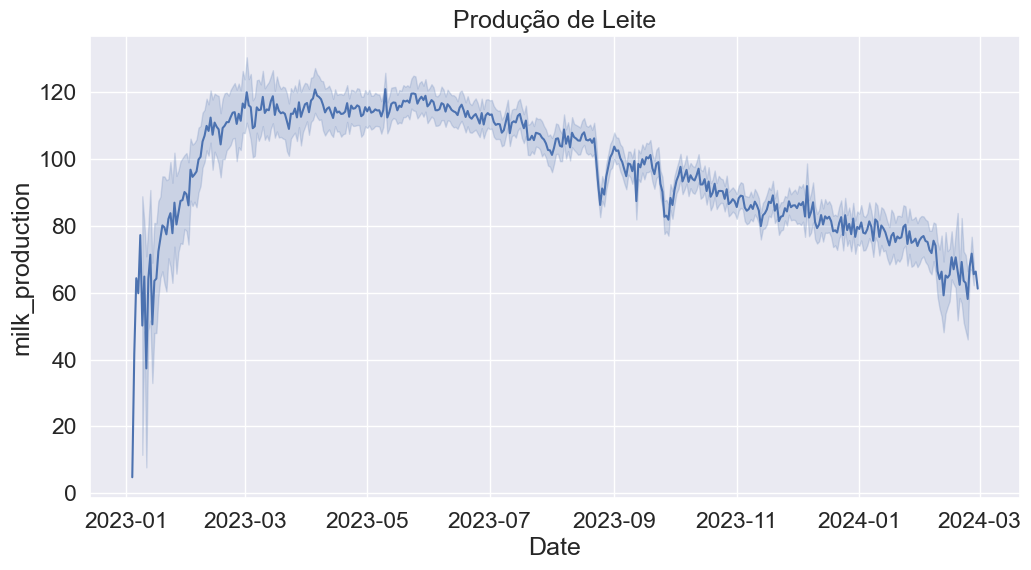

In [10]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_milk.index, y="milk_production", data=df_milk).set_title("Produção de Leite")

Armotizando a visualização:

Text(0.5, 0.9, 'Sub-amostragem para intervalos de 10 dias')

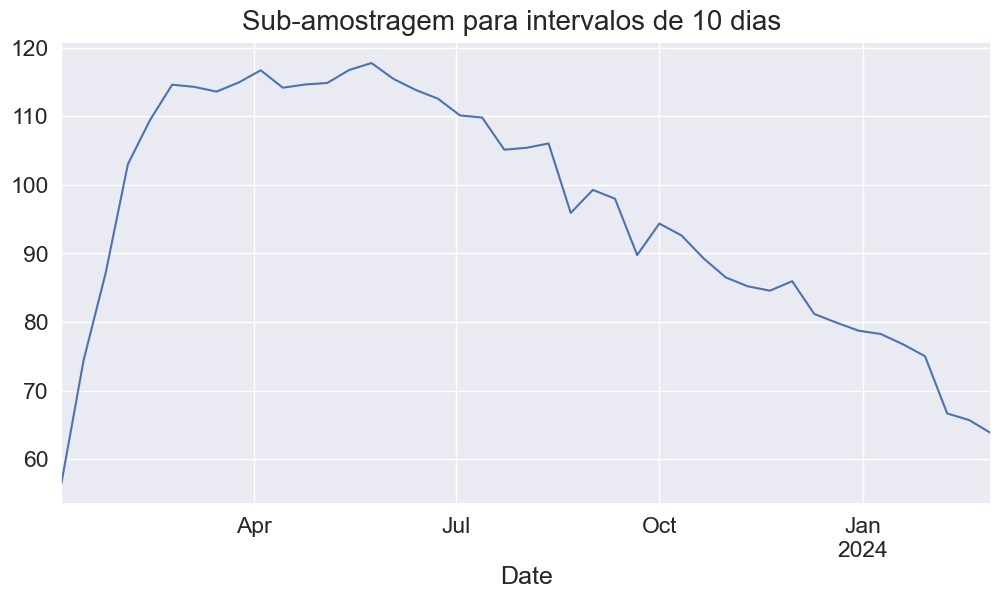

In [11]:
df_milk['milk_production'].resample('10D').mean().plot(figsize=(12,6))
plt.figtext(x=.5,y=0.9, s="Sub-amostragem para intervalos de 10 dias", fontsize=20, ha='center')

# Model

Redes recorrentes são modelos poderosos para tratar sequências, pois eles mantêm o estado interno sobre as variações anteriores. Tais redes requerem uma matriz 3d com formato: (num_exemplos_treino, timesteps, input_dim).

Vamos construir um modelo usando timesteps=50 valores anteriores para prever o próximo valor. Como estamos usando apenas uma variável, input_dim=1.

## Pré-processamento dos dados
Reorganizando os dados de forma que uma sequencia de valores dos 50 dias anteriores seja usada para prever o próximo dia. Os valores também serão normalizados entre 0 e 1.

In [12]:
data_milk = df_milk.iloc[:, 1]
data_milk


Date
2023-01-09    11.5
2023-01-10    48.4
2023-01-11    66.4
2023-01-12    57.1
2023-01-13    78.5
              ... 
2023-12-13    72.8
2023-12-14    73.0
2023-12-15    70.9
2023-12-16    70.6
2023-12-17    67.7
Name: milk_production, Length: 25849, dtype: float64

In [13]:
hist_milk = []
target_milk = []
length = 20

for i in range(len(data_milk)-length):
    x = data_milk[i:i+length]
    y = data_milk[i+length]

    hist_milk.append(x)
    target_milk.append(y)

C:\Users\Lucri\AppData\Local\Temp\ipykernel_44080\3436550985.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = data_milk[i+length]


In [14]:
print(len(hist_milk[0]))
print(len(hist_milk))
print(len(target_milk))

20
25829
25829


In [15]:
print(hist_milk[0][length-1])
print(data_milk[length-1])

109.0
109.0


C:\Users\Lucri\AppData\Local\Temp\ipykernel_44080\3739301336.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hist_milk[0][length-1])
C:\Users\Lucri\AppData\Local\Temp\ipykernel_44080\3739301336.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data_milk[length-1])


In [16]:
print(hist_milk[1][length-1])
print(data_milk[length])
print(target_milk[0])
print(data.shape)

116.0
116.0
116.0


C:\Users\Lucri\AppData\Local\Temp\ipykernel_44080\3073688783.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(hist_milk[1][length-1])
C:\Users\Lucri\AppData\Local\Temp\ipykernel_44080\3073688783.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data_milk[length])


NameError: name 'data' is not defined

In [ ]:
#convertendo de lista para array
hist_milk = np.array(hist_milk)
target_milk = np.array(target_milk)

In [ ]:
hist_milk.shape
print(hist_milk)
print(hist_milk.shape)

In [ ]:
target_milk.shape

In [ ]:
target_milk = target_milk.reshape(-1,1)
target_milk.shape
target_milk

In [ ]:
#Forma correta de normalizar com MinMax (fazendo a divisão entre treino e validação)

total = len(hist_milk)
train_size = int(total * 0.6)
val_size = int(total * 0.2)

train_indices = range(0, train_size)
val_indices = range(train_size, train_size + val_size)
test_indices = range(train_size + val_size, total)


X_train = hist_milk[train_indices]
X_val = hist_milk[val_indices]
X_test = hist_milk[test_indices]

y_train = target_milk[train_indices]
y_val = target_milk[val_indices]
y_test = target_milk[test_indices]

##Normalizando...
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)


X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

X_train = X_train.reshape((len(X_train), length, 1)) #array 3d (entrada do LSTM). A terceira dimensão tem apenas 1 feature.
X_val = X_val.reshape((len(X_val), length, 1))

sc.fit(y_train)
y_train = sc.transform(y_train)
y_val = sc.transform(y_val)

In [ ]:
X_train.shape

In [ ]:
print('treinamento: ', (X_train.shape[0] / len(hist_milk)))
print('validação: ', (X_val.shape[0] / len(hist_milk)))
print('teste: ', (X_test.shape[0] / len(hist_milk)))

## Construindo a rede neural

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint


In [ ]:
model = tf.keras.Sequential()

#model.add(SimpleRNN(25, return_sequences=True, input_shape=(length,1)))
model.add(SimpleRNN(25, input_shape=(length,1)))

model.add(Dense(1))

model.summary()

Criamos um modelo com 1 camada de RNN e 1 camada densa de saída. Compilando e treinando o método...

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#checkpoint = ModelCheckpoint("best", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)


In [ ]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32,  callbacks=[checkpoint])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32)


Vamos visualizar os erros de treino e validação:



In [ ]:
loss = history.history['loss']
val_loss=history.history['val_loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, val_loss,  )
plt.legend(['Training Loss', 'Validation Loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Vamos fazer as predições:

In [ ]:
pred = model.predict(X_val)
#print(np.hstack((pred, y_val)))


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_val, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Preço')
plt.legend()
plt.show()

O modelo parece estar bem ajustado. Vamos verificar o valor real (sem normalização):

In [ ]:
pred_transformed = sc.inverse_transform(pred)
y_val_transformed = sc.inverse_transform(y_val)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_val_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Preço real')
plt.legend()
plt.show()

Fazendo a divisão dos dados de treinamento, validação e teste para cada instância:

In [ ]:
def get_data(csv="RecurrentNeuralNetwork/milk.csv", ratio1=0.6, ratio2=0.2):
    df = pd.read_csv(csv)
    df = df[["AnEar", "milk_production", "Date"]]

    dfs = {"train":[], "val":[], "test":[],}
    for vaca in df["AnEar"].unique():
        df_vaca = df[df["AnEar"]==vaca]
        l1, l2 = int(ratio1 * len(df_vaca)), int(ratio2 * len(df_vaca))
        dfs["train"].append(df_vaca.iloc[0:l1,:])
        dfs["val"].append(df_vaca.iloc[l1:l1+l2,:])
        dfs["test"].append(df_vaca.iloc[l1+l2:,:])

    df_train = pd.concat(dfs["train"])
    df_val = pd.concat(dfs["test"])
    df_test = pd.concat(dfs["val"])

    return df_train, df_val, df_test

df_train, df_val, df_test = get_data()
print("Tamanho do conjunto de total:", df.shape)
print("Tamanho do conjunto de treino:", df_train.shape)
print("Tamanho do conjunto de validação:", df_val.shape)
print("Tamanho do conjunto de teste:", df_test.shape)

In [ ]:
df_train['AnEar'].value_counts()

o último ponto do exemplo de treino 1 (hist\[1\]) é a rotulação do exemplo de treino 0 e o elemento length do dado original. double check: